In [ ]:
# 모델의 학습/검증/테스트에 이용된 Teeth Segmentation on dental X-ray images 데이터셋이 아닌 
# 추가적으로 확보한 Panoramic Dental X-rays With Segmented Mandibles 데이터셋으로 세그먼테이션 예측 수행
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
from modules.UNet import UNet 

In [ ]:
# U-Net 모델 생성
model = UNet()

# 저장된 레이어의 가중치와 편향 불러와서, 생성한 U-Net 모델에 로드
state_dict = torch.load("Unet_best_model_checkpoint.pth")
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for NestedUNet:
	Missing key(s) in state_dict: "final.weight", "final.bias". 
	Unexpected key(s) in state_dict: "final1.weight", "final1.bias", "final2.weight", "final2.bias", "final3.weight", "final3.bias". 

In [3]:
# 세그먼테이션 예측을 위한 데이터셋 클래스
class TestDataset(Dataset):
    def __init__(self, images_dir ,transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_ids = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, image_id)
        
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [4]:
test_image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
images_dir = r"your_path_here"
test_dataset = TestDataset(images_dir=images_dir, transform=test_image_transforms)

In [6]:
print(test_dataset.image_ids)

['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '5.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '6.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '7.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '8.png', '80.png', '81.png', '82.png', '83.png', 

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"현재 사용 중인 GPU: {device_name}")
else:
    print("CUDA 사용 불가, CPU 사용 중!")

현재 사용 중인 GPU: NVIDIA GeForce RTX 4060 Laptop GPU


Random test sample index: 69


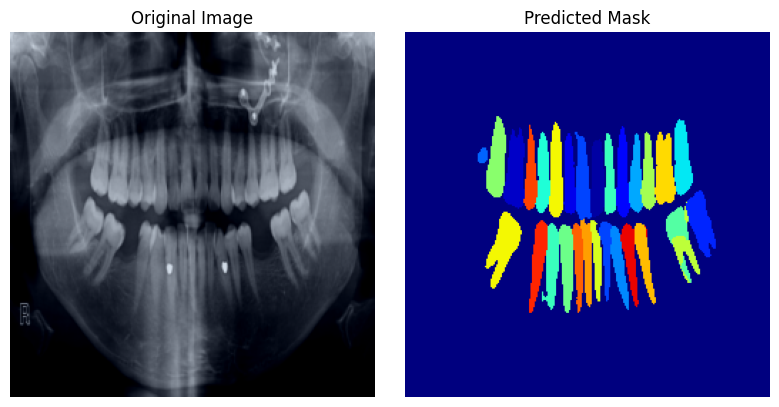

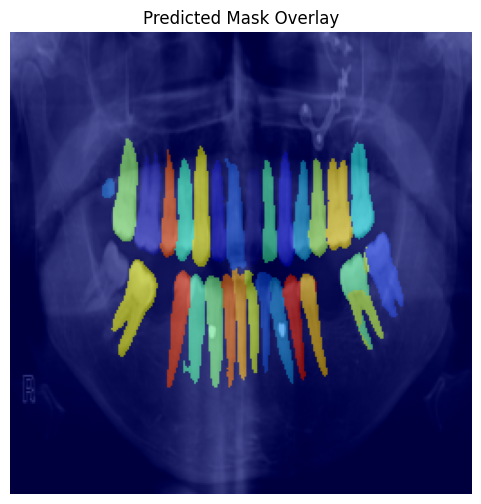

In [44]:
model.eval()
model.to(device)
num_classes = 32
rand_idx = random.randint(0, len(test_dataset)-1)
print(f"Random test sample index: {rand_idx}")
image = test_dataset[rand_idx]
image_tensor = image.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_tensor)

# 모델 출력에서 가장 높은 값(가장 확률이 높은 클래스) 선택하여 마스크 생성    
# argmax를 사용해 채널 차원을 제거하고 2D 마스크로 변환
pred_mask = torch.argmax(output, dim=1).squeeze(0)

# 텐서를 (H, W, C) 형식의 numpy 배열로 변환
img_np = image.cpu().numpy().transpose(1, 2, 0)
mean = np.array([0.3439, 0.3439, 0.3439])
std = np.array([0.2127, 0.2127, 0.2127])

# 정규화 해제 (원래 픽셀 값으로 복원)
img_np = std * img_np + mean

# 값의 범위를 0~1로 제한하여 시각적으로 이상이 없도록 처리
img_np = np.clip(img_np, 0, 1)

# 예측 마스크를 numpy 배열로 변환
pred_mask_np = pred_mask.cpu().numpy()

# 원본 이미지, 예측 마스크 표시 
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_np, cmap='jet', vmin=0, vmax=num_classes-1)
plt.title("Predicted Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

# 원본 이미지 위에 예측 마스크를 반투명하게 표시
plt.figure(figsize=(6, 6))
plt.imshow(img_np)  # 원본 이미지 표시
# 예측 마스크를 jet 컬러맵과 alpha=0.5로 오버레이
plt.imshow(pred_mask_np, cmap='jet', alpha=0.5, vmin=0, vmax=num_classes-1)
plt.title("Predicted Mask Overlay")
plt.axis("off")
plt.show()